Conditional correlation analysis

In [1]:
# python modules
import sys
import copy
import re
import random
import glob
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy
from scipy import stats

In [2]:
# custom modules
sys.path.append('/Users/sangwoopark/Projects/condense-seq/postpro_scripts')
import graphics_edit as graphics
import load_file_edit as load_file
import Interval_dict
import statis_edit as statis

In [3]:
# matplotlib setting
%matplotlib inline
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["savefig.facecolor"] = "white"

In [4]:
### parameters
cell_org = {'H1':'human',
            'GM':'human',
            'mCD8T:WT':'mouse',
            'mCD8T:DFMO':'mouse',
            'mCD8T:ODCKO':'mouse'}

cell_chrnames = {'H1':['chr%s' % (i) for i in range(1, 23)] + ['chrX', 'chrY'],
                 'GM':['chr%s' % (i) for i in range(1, 23)] + ['chrX'],
                 'mCD8T:WT':['chr%s' % (i) for i in range(1, 20)] + ['chrX'],
                 'mCD8T:DFMO':['chr%s' % (i) for i in range(1, 20)] + ['chrX'],
                 'mCD8T:ODCKO':['chr%s' % (i) for i in range(1, 20)] + ['chrX']}

In [5]:
### load gtab file
gtab_path = '/Users/sangwoopark/jhu_rockfish/2024_01_05_GEO/processed_files/'

dinfo_dkey = {'H1_NCP_sp_1rep_deep_chr1_score_table.gtab.gz':None}
dkey_ID_value = load_file.read_gtab_batch (dinfo_dkey,
                                           data_path=gtab_path)

loading H1_NCP_sp_1rep_deep_chr1_score_table.gtab.gz


Done


In [6]:
### compute sequence features
# change dkey name
dkey_ID_value['AT content'] = copy.deepcopy(dkey_ID_value['ATcontent'])
del dkey_ID_value['ATcontent']

# methylation density
dkey_ID_value['meCpG density'] = statis.get_fract_dict(dkey_ID_value['meCNumber(CpG)'],
                                                       dkey_ID_value['CNumber(CpG)'])
dkey_ID_value['meCHG density'] = statis.get_fract_dict(dkey_ID_value['meCNumber(CHG)'],
                                                       dkey_ID_value['CNumber(CHG)'])
dkey_ID_value['meCHH density'] = statis.get_fract_dict(dkey_ID_value['meCNumber(CHH)'],
                                                       dkey_ID_value['CNumber(CHH)'])


In [7]:
### compute sequence features
# mean poly GC length
ID_polyGC = {}
for ID, seq in dkey_ID_value['Sequence'].items():
    num_pos = statis.polynt_count(seq.upper(), nts='GC', pos=True)
    mean_len, count = 0.0, 0.0
    for num, pos in num_pos.items():
        mean_len += len(pos)*num
        count += len(pos)
    ID_polyGC[ID] = mean_len/count

dkey_ID_value['poly-G/C length'] = ID_polyGC

del dkey_ID_value['Sequence']
del ID_polyGC


In [8]:
### select feature set and target for analysis
#seq_features = ['AT content', 'poly-G/C length']
seq_features = []

epigenetic_features = ['meCpG density', 'meCHG density', 'meCHH density', 'H2AFZ', 'H2AK5ac', 'H2BK120ac', 'H2BK12ac', 'H2BK15ac', 'H2BK20ac', 'H2BK5ac', 'H3K14ac', 'H3K18ac', 'H3K23ac', 'H3K23me2', 'H3K27ac', 'H3K27me3', 'H3K36me3', 'H3K4ac', 'H3K4me1', 'H3K4me2', 'H3K4me3', 'H3K56ac', 'H3K79me1', 'H3K79me2', 'H3K9ac', 'H3K9me3', 'H4K20me1', 'H4K5ac', 'H4K8ac', 'H4K91ac']

features = seq_features + epigenetic_features

In [9]:
### set target for analysis
target = 'H1_NCP_sp_8_1rep_deep'

In [10]:
### Partition data by score
ID_score = dkey_ID_value[target]

# set partition lines and windows
med = np.median(ID_score.values())
std = np.std(ID_score.values())
p_lines = [med-0.5*std-i*std for i in range(3)]
p_lines += [med+0.5*std+i*std for i in range(3)]
p_lines = sorted(p_lines)
p_num = len(p_lines)+1
p_wins = []
for i in range(p_num):
    if i == 0:
        st = -np.inf
        ed = p_lines[i]
    elif i == p_num-1:
        st = ed
        ed = np.inf
    else:
        st = ed
        ed = p_lines[i]
    p_wins.append((st, ed))

In [11]:
# get partitions
p_IDs = statis.partition(ID_score, p_wins)

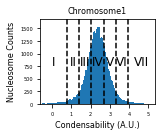

In [12]:
# plot partition [Extended Data Fig.5b]
graphics.plot_partition (ID_score,
                         p_wins,
                         hist_bins=10000,
                         xlabel="Condensability (A.U.)",
                         ylabel="Nucleosome Counts",
                         title="Chromosome1",
                         xlim=[med-3, med+3],
                         ylim=None,
                         fig_width=2.4,
                         fig_height=2,
                         ax=None,
                         save_path='./data/',
                         save=True,
                         note='H1_NCP_sp')

In [13]:
### get feature values/z-scores for each partitions
feature_p_values = {}
feature_p_zscores = {}
for feature in features:
    print feature
    ID_value = dkey_ID_value[feature]
    p_values = []
    for i in range(p_num):
        values = [ID_value[ID] for ID in p_IDs[i]]
        p_values.append(values)
    feature_p_values[feature] = p_values

    ID_zscore = statis.standardize_dict(ID_value)
    p_zscores = []
    for i in range(p_num):
        zscores = [ID_zscore[ID] for ID in p_IDs[i]]
        p_zscores.append(zscores)
    feature_p_zscores[feature] = p_zscores

meCpG density


meCHG density


meCHH density


H2AFZ


H2AK5ac


H2BK120ac


H2BK12ac


H2BK15ac


H2BK20ac


H2BK5ac


H3K14ac


H3K18ac


H3K23ac


H3K23me2


H3K27ac


H3K27me3


H3K36me3


H3K4ac


H3K4me1


H3K4me2


H3K4me3


H3K56ac


H3K79me1


H3K79me2


H3K9ac


H3K9me3


H4K20me1


H4K5ac


H4K8ac


H4K91ac


In [14]:
### plot box plot for feature values of each partitions
for feature in features:
    p_values = feature_p_values[feature]
    fig = plt.figure()
    plt.xlabel('Partitions')
    plt.title(feature)
    plt.boxplot(p_values, 0, "")
    #plt.savefig('pbox_%s.png' % (feature))
    #plt.show()
    plt.close()
    

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/cbook/__init__.py:1879: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = np.compress(x <= hival, x)
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/cbook/__init__.py:1886: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = np.compress(x >= loval, x)
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/cbook/__init__.py:1894: RuntimeWarning: invalid value encountered in less
  np.compress(x < stats['whislo'], x),
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/cbook/__init__.py:1895: RuntimeWarning: invalid value encountered in greater
  np.compress(x >

In [15]:
### make heatmap for mean z-scores of each partitions
group_num = 1
group_size = len(features)/group_num

img_list = [[] for i in range(group_num)]
ytick_labels_list = [[] for i in range(group_num)]

for i in range(len(features)):
    feature = features[i]
    g_idx = i / group_size
    p_zscores = feature_p_zscores[feature]
    p_mzscore = [np.nanmean(p_zscores[i]) for i in range(p_num)]
    img_list[g_idx].append(p_mzscore)
    ytick_labels_list[g_idx].append(feature)

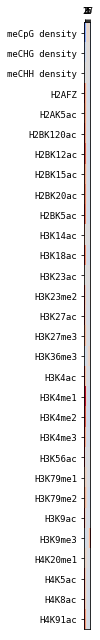

In [24]:
### make heatmap for z-scores of each partitions [Extended Data Fig.5d]
graphics.plot_partition_heatmap (img_list[0],
                                 ytick_labels=ytick_labels_list[0],
                                 fig_width=1.5,
                                 fig_height=9,
                                 vmin=-1.5,
                                 vmax=1.5,
                                 cmap='coolwarm',
                                 save_path='./data/',
                                 save=True,
                                 note='H1_NCP_sp')